# Лабораторная работа №1. Основы машинного обучения

### Данные: В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.

Ниже будут прописаны все библиотеки, которые мы используем в лабораторной работе

In [1]:
import pathlib
import tensorflow as tf
import requests
import tarfile
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

#### 1. Сначала загрузим наши данные

In [3]:
url = "https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz"
download_dir = "notMNIST_dataset"


if not os.path.exists(download_dir):
    os.makedirs(download_dir)

response = requests.get(url)
with open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "wb") as f:
    f.write(response.content)

with tarfile.open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "r:gz") as tar:
    tar.extractall(download_dir)

print("Данные успешно загружены и извлечены.")

Данные успешно загружены и извлечены.


In [4]:
data_dir = os.path.join(download_dir, "notMNIST_large")
data_dir = pathlib.Path(data_dir)

#### С помощью функции plot_image выведем по одному изображению каждой буквы

In [5]:
def plot_image(directory, label, count):
    images = list(directory.glob(f"{label}/*.png"));
    image = PIL.Image.open(images[count])
    plt.figure()
    plt.imshow(image)
    plt.title(f"Изображение {label}")
    plt.show()

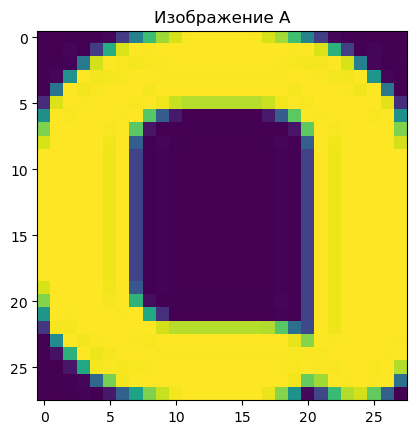

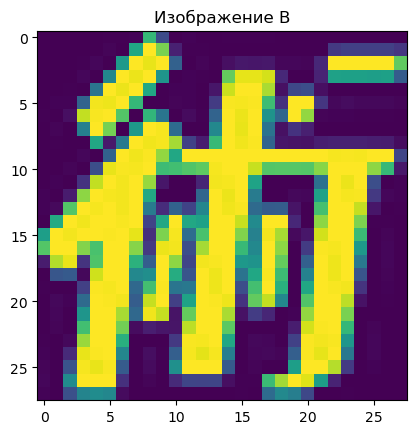

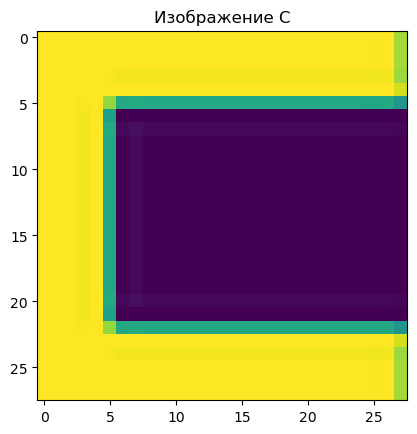

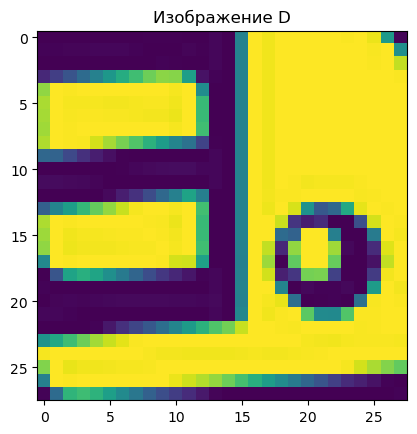

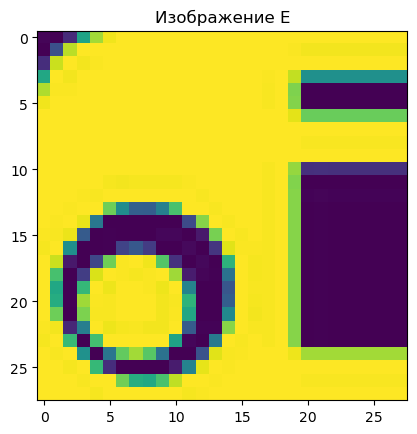

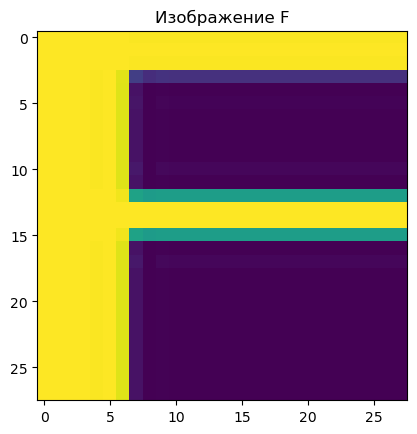

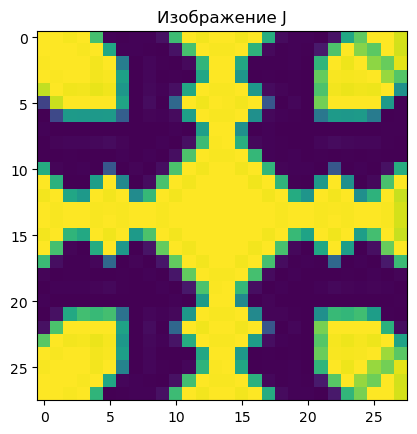

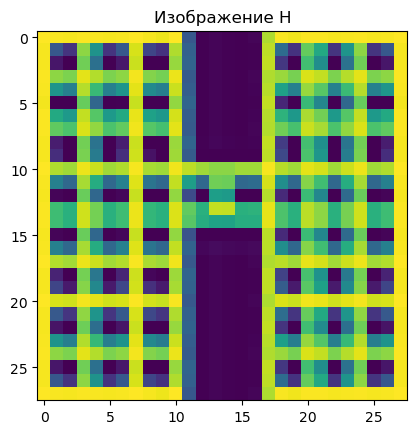

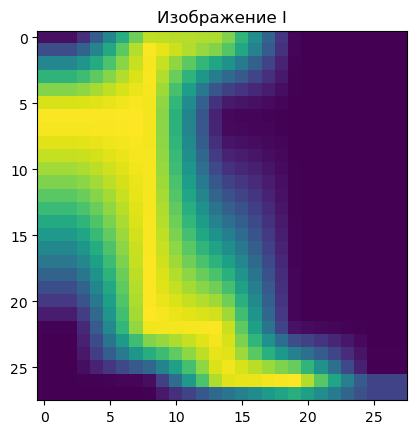

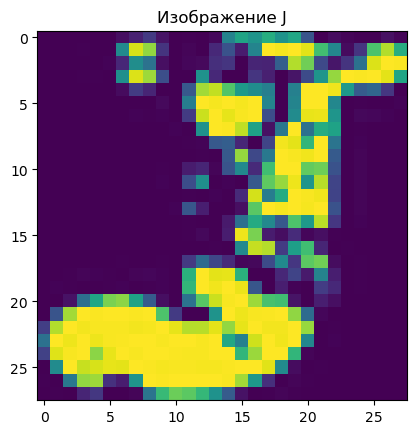

In [6]:
for index, char in enumerate(['A', 'B', 'C', 'D', 'E', 'F', 'J', 'H', 'I', 'J']):
    plot_image(data_dir, char, index + 1)

#### 2. Проверим наш датасет на сбалансированность

In [9]:
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [10]:
number_of_labels = {}
total_number_of_labels = 0
balanced_labels = {}
for label in classes:
    number_of_labels[label] = len(list(data_dir.glob(f"{label}/*.png")))
    total_number_of_labels += number_of_labels[label]
print(number_of_labels)

average_number_of_labels = total_number_of_labels / len(number_of_labels)

for label in classes:
    balanced_labels[label] = average_number_of_labels / number_of_labels[label]
print(balanced_labels)


{'A': 52912, 'B': 52912, 'C': 52912, 'D': 52912, 'E': 52912, 'F': 52912, 'G': 52912, 'H': 52912, 'I': 52912, 'J': 52911}
{'A': 0.9999981100695494, 'B': 0.9999981100695494, 'C': 0.9999981100695494, 'D': 0.9999981100695494, 'E': 0.9999981100695494, 'F': 0.9999981100695494, 'G': 0.9999981100695494, 'H': 0.9999981100695494, 'I': 0.9999981100695494, 'J': 1.0000170096955265}


Наши данные сбалансированы, так как количество каждой буквы очень близко к значению, если бы каждой буквы было одинаковое количество

#### Перед тем как делить данные на выборки, "перемешаем" между картинки из разных папок собой, чтобы не получилось так, что в одной выборке все буквы одного из классов, а в другой выборке букв этого класса вообще нет


In [11]:
image_paths = list(data_dir.glob("*/*.png"))
image_paths.sort()
random.shuffle(image_paths)
print(image_paths[:1])

[WindowsPath('notMNIST_dataset/notMNIST_large/G/S2FiZWwgQm9sZCBCVC50dGY=.png')]


#### 4. Избавимся от дупликатов изображений

Для начала напишем функцию для вычисления дифференциального хеша (dHash) изображения, чтобы было проще убрать дупликаты

In [12]:
def dhash(image, hash_size=8):
    # Изменяем размер изображения до размера hash_size + 1 на hash_size  и преобразуем его в оттенки серого
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    hash_string = ""
    
    # Сравниваем пиксели по строкам
    for i in range(hash_size):
        for j in range(hash_size):
            if gray[i, j] > gray[i, j + 1]:
                hash_string += "1"
            else:
                hash_string += "0"

    return hash_string

Создадим словарь, где ключами будут все возможные различные кэши изображений, а значениями будут списки путей к картинкам, у которых конкретный кэш

In [13]:
image_hashes = {}
for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is not None:
        if image.shape[0] != 0 and image.shape[1] != 0:
            hashed_image = dhash(image)

            different_hashes = image_hashes.get(hashed_image, [])
            different_hashes.append(image_path)
            
            image_hashes[hashed_image] = different_hashes

А уже следующей функцией удалим все дупликаты изображений и оставим только первые картинки из повторяющихся

In [14]:
images_whithout_duplicates = []
hash_len = 0

for (different_hashes, hashes_paths) in image_hashes.items():
    images_whithout_duplicates.append(hashes_paths[0])
    hash_len += len(hashes_paths)
    
print(f"Было удалено {hash_len - len(images_whithout_duplicates)} дупликатов")

Было удалено 176474 дупликатов


#### 3. Разделим выборку

In [15]:
data = []
labels = []
for file in images_whithout_duplicates:
    image = cv2.imread(str(file))
    
    # Достаём в какой папке (и к какому классу соответственно, относится изображение)
    label = str(file.parent).split('\\')[-1]
    
    # с помощью reshape преобразуем изображение в одномерный массив и нормализуем каждый из 
    # полученных веторов с помощью деления его на 255. Таким образом все числа в массиве от 0 до 1
    data.append(image.reshape(-1)/255)
    
    # Добавляем в список labels индекс буквы (0-A, 1-B, 2-C,...)
    labels.append(classes.index(label))

In [16]:
x_train, x_test, y_train, y_test = train_test_split(np.array(data[:219000], np.float32), np.array(labels[:219000], np.float32),
                                                    test_size=19000/219000, random_state=42)

In [17]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


200000
19000
200000
19000


#### 5. Построим простейший классификатор с помощью логистической регрессии

Создадим и обучим модель логистической регрессии

In [18]:
model = LogisticRegression(max_iter=10000)
model.fit(x_train, y_train)

LogisticRegression(max_iter=10000)

Предскажем на тестовых данных и оценим точность

In [19]:
y_pred = model.predict(x_test)
accuracy = accuracy_score(y_test, y_pred)
    
print(accuracy)

0.7914210526315789


Для построения графика зависимости точности классификатора от размера обучающей выборки (50, 100, 1000, 50000), пусть наша тестовая (контрольная выборка) будет состоять из 10000 данных.

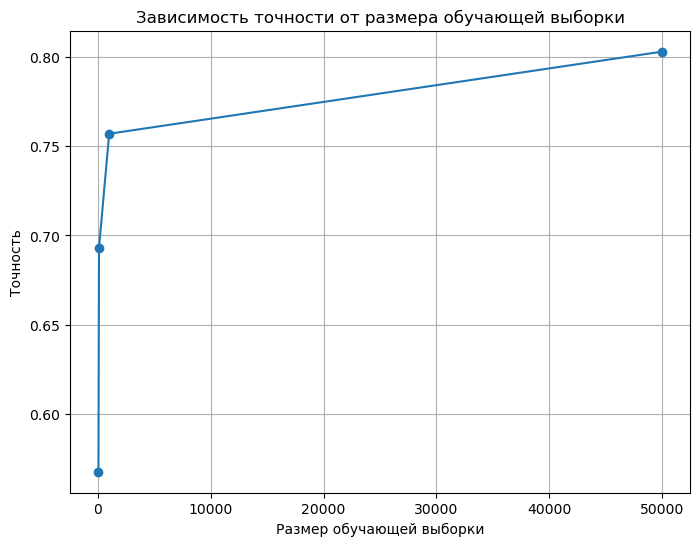

In [20]:
# Размеры обучающих выборок для анализа
sample_sizes = [50, 100, 1000, 50000]

accuracy_scores = []

for sample_size in sample_sizes:
    
    X_train, X_test, Y_train, Y_test = train_test_split(data[:sample_size+10000], labels[:sample_size+10000], 
                                                        test_size=10000/(sample_size+10000), random_state=42)
    
    model = LogisticRegression(max_iter=10000)
    model.fit(X_train, Y_train)

    Y_pred = model.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    
    accuracy_scores.append(accuracy)

plt.figure(figsize=(8, 6))
plt.plot(sample_sizes, accuracy_scores, marker='o', linestyle='-')
plt.title('Зависимость точности от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

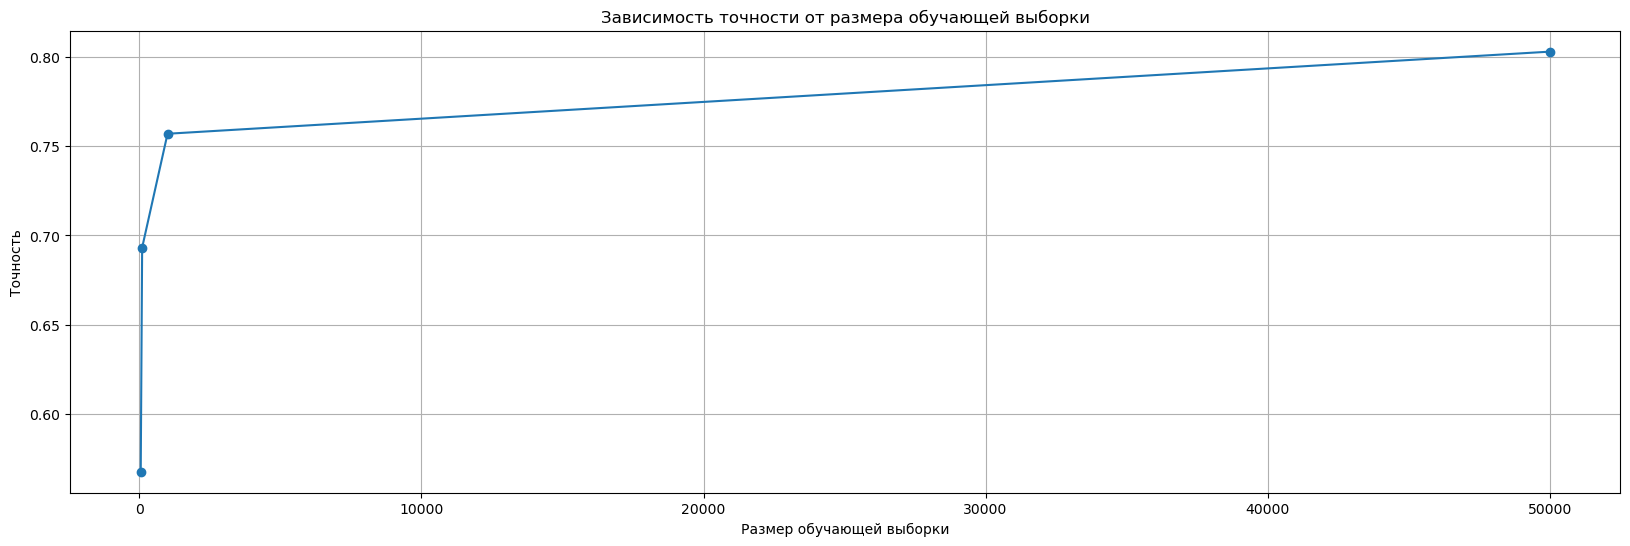

In [21]:
plt.figure(figsize=(20, 6))
plt.plot(sample_sizes, accuracy_scores, marker='o', linestyle='-')
plt.title('Зависимость точности от размера обучающей выборки')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('Точность')
plt.grid(True)
plt.show()

#### Из графика можно заметить, что при равной размерности тестовой выборки и при увеличивающийся размерности обучающей выборки, точность возрастает